In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from statsmodels.graphics.tsaplots import plot_acf
from scipy.stats import norm
import math

# Funciones necesarias

In [26]:
#test de hipotesis
def mostrar_ac(data,alfa):
    plt.rc("figure", figsize=(10,6))

    #funcion de autocorrelacion y ploteo
    plot_acf(data, lags=7,alpha=alfa,bartlett_confint=False)

    plt.ylim(-1,1)
    plt.xlabel('lags', fontsize=10)
    plt.ylabel('Correlacion', fontsize=10)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.title(' Ploteo de Autocorrelacion', fontsize=7)
    plt.tight_layout()
    plt.show()

    
#pronosticos
#Estacionarios/horizontales
#promedio movil simple
def pms(data, a):
    #a= tamaño de la ventana
    series = pd.Series(data)
    sma = series.rolling(window=a).mean().shift(1)
    # se desliza una posicion dado que estos metodos tambien se aplica para suavizar los valores.
    if len(series) >= a:
        futuro = pd.Series([series.iloc[-a:].mean()])
    else:
        futuro = pd.Series([np.nan])
    
    resultado = pd.concat([sma, futuro], ignore_index=True)
    
    return resultado

#atenuacion exponencial simple
def aes(data,a):
    series =pd.Series(data) 
    aes = series.ewm(alpha=a, adjust=False).mean().shift(1)
    futuro = pd.Series([series.ewm(alpha=a, adjust=False).mean().iloc[-1]])
    resultado = pd.concat([aes, futuro], ignore_index=True)

    return resultado

#tendencia
#promedio movil doble
def pmd(data, a):
    #a= tamaño de la ventana
    series = pd.Series(data)

    pmd1 = series.rolling(window=a).mean()
    pmd2 = pmd1.rolling(window=a).mean()

    at = 2 * pmd1 - pmd2
    bt = (2 / (a - 1)) * (pmd1 - pmd2)

    resultado = at + bt
    resultado_shifted = resultado.shift(1)
    #2*a dado que me desplaze el doble
    if len(series) >= 2 * a:
        futuro = pd.Series([resultado.iloc[-1]])
    else:
        futuro = pd.Series([pd.NA])

    resultado_final = pd.concat([resultado_shifted, futuro], ignore_index=True)

    return resultado_final
#atenuacion exponencial doble de Brown
def aed(data, alfa):
    #alfa= parametro de suavizado a las observaciones
    
    series = pd.Series(data)
    n = len(series)

    S1 = pd.Series(index=series.index, dtype='float64')
    S2 = pd.Series(index=series.index, dtype='float64')
    
    S1.iloc[0] = series.iloc[0]
    S2.iloc[0] = series.iloc[0]

    for t in range(1, n):
        S1.iloc[t] = alfa * series.iloc[t] + (1 - alfa) * S1.iloc[t - 1]
        S2.iloc[t] = alfa * S1.iloc[t] + (1 - alfa) * S2.iloc[t - 1]

    a_t = 2 * S1 - S2
    b_t = (alfa / (1 - alfa)) * (S1 - S2)

    resultado = a_t + b_t

    futuro = pd.Series([resultado.iloc[-1]])

    resultado_shifted = resultado.shift(1)

    resultado_final = pd.concat([resultado_shifted, futuro], ignore_index=True)

    return resultado_final

#Atenuacion exponencial doble de Holt
def aeh(data, alfa, beta):
    #alfa= parametro de suavizado a las observaciones
    #beta= parametro de suavizado a la tendencia (pendiente)
    series = pd.Series(data)
    n = len(series)

    l = pd.Series(index=series.index, dtype='float64')
    T = pd.Series(index=series.index, dtype='float64')
    yt = pd.Series(index=series.index, dtype='float64')

    l.iloc[0] = series.iloc[0]
    T.iloc[0] = 0

    for t in range(1, n):
        l.iloc[t] = alfa * series.iloc[t] + (1 - alfa) * (l.iloc[t - 1] + T.iloc[t - 1])
        T.iloc[t] = beta * (l.iloc[t] - l.iloc[t - 1]) + (1 - beta) * T.iloc[t - 1]
        yt.iloc[t] = l.iloc[t - 1] + T.iloc[t - 1]

    yt1 = l.iloc[n - 1] + T.iloc[n - 1]
    
    resultado = pd.concat([yt, pd.Series([yt1])], ignore_index=True)

    return resultado

#Regresion lineal
def rl(data):
    series = pd.Series(data)
    n = len(series)
    
    t = pd.Series(range(n))

    t_mean = t.mean()
    y_mean = series.mean()

    num = ((t - t_mean) * (series - y_mean)).sum()
    den = ((t - t_mean)**2).sum()
    b = num / den

    a = y_mean - b * t_mean

    pronostico = a + b * t
    pronostico_futuro = a + b * n
    
    resultado = pd.concat([pronostico, pd.Series([pronostico_futuro])], ignore_index=True)

    return resultado

#medicion
def calcular_errores(data,pron):
    
    pron = pron.iloc[:-1]
    y_true, y_pred = np.array(data), np.array(pron)
    mask = ~np.isnan(y_true) & ~np.isnan(y_pred)
    y_true_clean = y_true[mask]
    y_pred_clean = y_pred[mask]
    
    #DAM
    dam= np.mean(np.abs((y_true_clean - y_pred_clean)))
    
    #EMC
    emc= np.mean(pow((y_true_clean - y_pred_clean),2))
    
    #PEMA
    pema = np.mean(np.abs((y_true_clean - y_pred_clean)/y_true_clean))*100
    
    #PME
    pme = np.mean((y_true_clean - y_pred_clean)/y_true_clean)*100
    
    return dam,emc,pema,pme


def mostrar_resultados(y_true,y_pred):
    dam,emc,pema,pme = calcular_errores(y_true,y_pred)
    print(f"DAM : {dam}")
    print(f"EMC : {emc}")
    print(f"PEMA: {pema}")
    print(f"PME: {pme}")
    

In [42]:
def mejoralfa(Data2):
    resultados = []
    for x in np.arange(0,1,0.1):
        pred = aed(Data2,x)
        dam,emc,pema,pme = calcular_errores(Data2,pred)
        resultados.append([dam,x])
    
    resultados=np.array(resultados)
    i_min = np.argmin(resultados[:,0])
    mejor_dam = resultados[i_min,0]
    mejor_alfa = resultados[i_min,1]
    
    print(f"El alfa mas acorde en aed con datos ingresados es {mejor_alfa} con un error de  {mejor_dam}")

In [23]:
Data2 = [61562,66509,72386,80306,82884,85965,95183,103394,110136,113993,113531,116844,121903,122511,126553,138071,151079,114177,128003,133474,140488,150402]

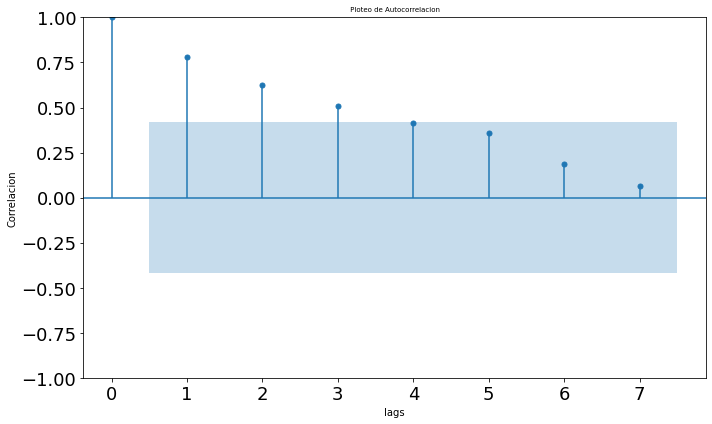

In [24]:
# 95%

mostrar_ac(Data2,0.05)


# Conclusiones Data2

- hipotesis nula (La serie de tiempo puede contener un patron predominantemente aleatorio)
- hipotesis alternativa (La serie de tiempo contiene un patron predominantemente no aleatorio)

- Existen autocorrelaciones fuera del intervalo de confianza. Se prueba que existen pruebas suficientes para rechazar la hipotesis nula. 

- Patron predominante: Tendencia.


In [28]:
#promedio movil doble con ventana de 3
exp1=pmd(Data2,3)
print("Experimento 1: Promedio movil doble con ventana de 3")
print(exp1)

#promedio movil doble con ventana de 6
print("Experimento 2: Promedio movil doble con ventana de 6")
exp2=pmd(Data2,6)
print(exp2)

Experimento 1: Promedio movil doble con ventana de 3
0               NaN
1               NaN
2               NaN
3               NaN
4               NaN
5      89968.444444
6      92725.666667
7      97640.222222
8     107268.888889
9     118204.777778
10    122905.666667
11    121238.666667
12    120023.333333
13    122432.222222
14    126168.222222
15    129966.333333
16    138388.333333
17    154857.444444
18    135290.333333
19    123861.444444
20    115156.222222
21    141769.888889
22    157256.666667
dtype: float64
Experimento 2: Promedio movil doble con ventana de 6
0               NaN
1               NaN
2               NaN
3               NaN
4               NaN
5               NaN
6               NaN
7               NaN
8               NaN
9               NaN
10              NaN
11    123480.155556
12    127919.072222
13    130962.761111
14    131656.227778
15    132099.311111
16    135980.477778
17    144981.272222
18    139200.633333
19    137728.683333
20    138519.033333

In [29]:
#Atenuacion exponencial doble de Brown con alfa 0.4
exp3= aed(Data2,0.4)
print("Atenuacion exponencial doble con alfa 0.4")
print(exp3)
exp4 = aed(Data2,0.9)
print(exp4)

Atenuacion exponencial doble con alfa 0.4
0               NaN
1      61562.000000
2      65519.600000
3      71804.240000
4      80495.792000
5      85656.784000
6      89535.895680
7      97735.432576
8     106847.676646
9     114969.096248
10    120205.111905
11    120726.539637
12    122413.367278
13    126176.726465
14    127334.139538
15    130212.705918
16    139877.836868
17    153474.590111
18    128464.526861
19    128235.699793
20    132492.890082
21    139793.656173
22    150464.226978
dtype: float64
0               NaN
1      61562.000000
2      70466.600000
3      77928.590000
4      87769.712000
5      86462.916500
6      89096.726180
7     103178.766071
8     111622.815952
9     117177.515530
10    118472.034946
11    114025.361834
12    119543.862017
13    126518.358785
14    123944.063137
15    130033.139040
16    148007.517177
17    163553.082045
18     87180.931237
19    133170.825427
20    139292.585773
21    147265.948900
22    159700.743922
dtype: float64


In [31]:
exp5 = aed(Data2, 0.01)

In [33]:
exp6 = aeh(Data2, 0.4, 0.5)
print(exp6)
exp7 = aeh(Data2, 0.4, 0.3)
print(exp7)

0               NaN
1      61562.000000
2      64530.200000
3      70233.080000
4      78837.392000
5      85840.500800
6      91299.665920
7      99039.031808
8     107838.044979
9     116273.843886
10    122421.954453
11    124147.829903
12    125047.789192
13    126982.406927
14    127492.096183
15    129226.890500
16    136643.788990
17    149184.170286
18    134946.165006
19    130545.128837
20    130678.681369
21    135526.276614
22    145375.578438
dtype: float64
0               NaN
1      61562.000000
2      64134.440000
3      69018.891200
4      76472.014976
5      82744.527444
6      88126.891632
7      95890.243149
8     104733.104881
9     113383.969335
10    120190.371687
11    123290.288496
12    125701.883961
13    128716.575165
14    130023.920868
15    132008.617785
16    138534.121802
17    149158.009595
18    136573.821120
19    133525.209500
20    133878.297389
21    137688.914435
22    145466.454930
dtype: float64


In [34]:
exp8 = rl(Data2)
print(exp8)

0      70196.260870
1      74027.586674
2      77858.912479
3      81690.238283
4      85521.564088
5      89352.889893
6      93184.215697
7      97015.541502
8     100846.867307
9     104678.193111
10    108509.518916
11    112340.844720
12    116172.170525
13    120003.496330
14    123834.822134
15    127666.147939
16    131497.473744
17    135328.799548
18    139160.125353
19    142991.451158
20    146822.776962
21    150654.102767
22    154485.428571
dtype: float64


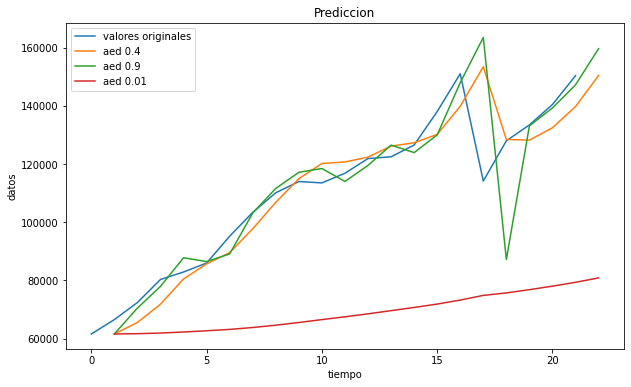

In [32]:
plt.plot(Data2, label='valores originales')
plt.plot(exp3, label='aed 0.4')
plt.plot(exp4, label='aed 0.9')
plt.plot(exp5, label='aed 0.01')
plt.xlabel('tiempo')
plt.ylabel('datos')
plt.title('Prediccion')
plt.legend()
plt.show()

In [37]:
#medicion de los experimentos
resultados = [exp1,exp2,exp3,exp4,exp5,exp6,exp7,exp8]
for x in resultados:
    print("")
    mostrar_resultados(Data2,x)


DAM : 8690.91503267973
EMC : 172668955.8678283
PEMA: 7.0350141538218285
PME: -0.2229519800476274

DAM : 9573.661616161608
EMC : 148525971.85293475
PEMA: 7.518364322858323
PME: -3.4745245787466024

DAM : 6512.185157523036
EMC : 106425275.13672593
PEMA: 5.8943309551459055
PME: 1.240564408876186

DAM : 7060.834236468417
EMC : 207523485.4971472
PEMA: 6.212225615794719
PME: 0.3564342705637586

DAM : 44205.989092612625
EMC : 2323572456.94104
PEMA: 36.99777077912045
PME: 36.99777077912045

DAM : 7497.979715201713
EMC : 109434327.76062766
PEMA: 6.686010168528271
PME: 1.05369075228713

DAM : 7752.573636391589
EMC : 107360082.31476629
PEMA: 7.143621700001379
PME: 1.4599378139581685

DAM : 7040.791643139467
EMC : 76612758.67173141
PEMA: 6.515047335019274
PME: -0.8291948403534368


# Conclusiones Data2
- DAM -> EXP3
- EMC ->EXP8
- PEMA ->EXP3
- PME -> EXP1

Se concluye que el mejor modelo fue la atenuacion exponencial doble de Brown con alfa 0.4


In [43]:
mejoralfa(Data2)

El alfa mas acorde en aed con datos ingresados es 0.4 con un error de  6512.185157523036


# Ejemplo 2

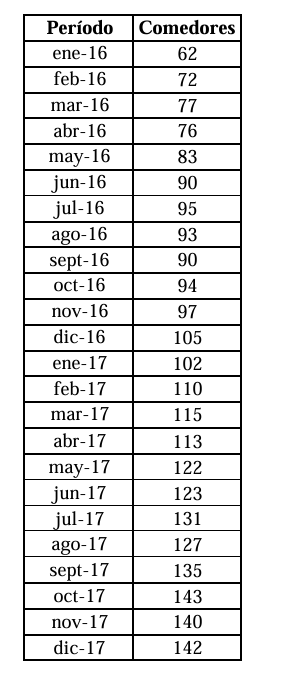

In [ ]:
data3 = [62,72,77,76,83,90,95,93,90,94,97,105,102,110,113,122,123,131,127,135,143,140,142]

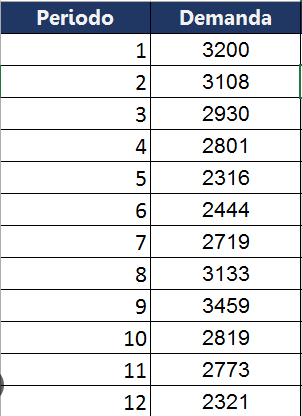

In [ ]:
data4 = [3200,3108,2930,2801,2316,2444,2719,3133,3459,2819,2773,2321]